In cell_seg_pipeline.ipynb, there were low cell counts. We can take advantage of the fact that spheroids are symmetric to fix this.

In [2]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
from library import plots
import math
from scipy import interpolate
from cellpose import plot, utils
import os
from scipy.spatial import ConvexHull
percent_of_side = 0.10

## Read in Data

Note: The two channel images seem to have an offset. This messed up the analysis. I had to manually adjust the offset in the preprocessing step.

In [3]:
_, blue = cv2.imreadmulti('data/Blue-34a-dbl_0002.tiff', [], cv2.IMREAD_UNCHANGED)
_, red = cv2.imreadmulti('data/Red-34a-dbl_0002.tiff', [], cv2.IMREAD_UNCHANGED)
_, composite = cv2.imreadmulti('data/Composite-34a-dbl_0002.tiff', [], cv2.IMREAD_GRAYSCALE)

rows,cols = red[42].shape
M = np.float32([[1,0,10],[0,1,-3]])

# List of tuples of the form (blue, red) 
red_offset = [cv2.warpAffine(red[i],M,(cols,rows)) for i in range(len(red))]
blue_composite = [(blue[i], composite[i]) for i in range(len(composite))]

## Create segmentations of blue and red

In [60]:
# RUN CELLPOSE
import os
from cellpose import models, io
from cellpose import plot

# DEFINE CELLPOSE MODEL
model = models.CellposeModel(gpu=False, model_type='CPx')
folders = ['red','blue']
for folder in folders:
    if not os.path.exists(folder):
        os.mkdir(folder)

chan = [0,0]
for idx,img_red in enumerate(red_offset):
    if idx >= len(red)*percent_of_side and idx <= len(red)*(1-percent_of_side):
        masks, flows, diams = model.eval(img_red, diameter=45.6,flow_threshold=0.4, channels=chan)
        io.masks_flows_to_seg(img_red, masks, flows, 45.6, f'red/{idx}', chan)

chan = [0,0]
for idx,img_blue in enumerate(blue):
    if idx >= len(red)*percent_of_side and idx <= len(red)*(1-percent_of_side):
        masks, flows, diams = model.eval(img_blue, diameter=45.6,flow_threshold=0.4, channels=chan)
        io.masks_flows_to_seg(img_blue, masks, flows, 45.6, f'blue/{idx}', chan)

## Use segmentations to create plots

#### Find limits of data


In [4]:
from library import plots
max_limit = plots.max_limit(red)
print(max_limit)

3775.27693856999


#### Check number of cells in each frame 
The data doesn't include the entire spheroid. Some of the top of the spheroid wasn't captured.
To take advantage of the symmetry seen in the plot below we need to find the matching frame number on the bottom of the spheroid which seems to be 91.

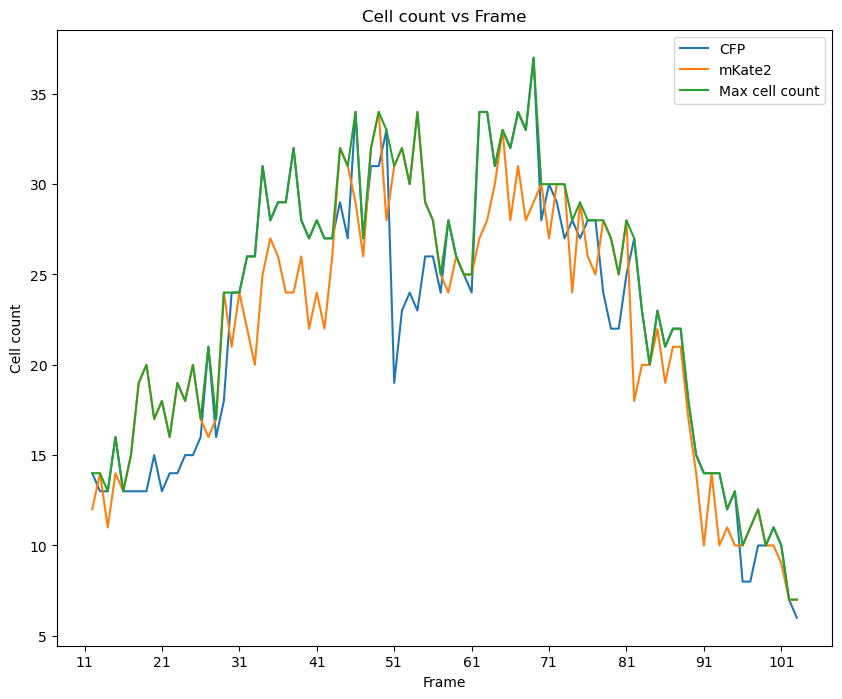

In [4]:
# Check number of cells in each frame using the segmentation masks
frames = []
for i in range(len(red)):
        if i >= len(red)*percent_of_side and i <= len(red)*(1-percent_of_side):
            frames.append(i)
cell_counts = []
for i in range(len(red)):
        if i >= len(red)*percent_of_side and i <= len(red)*(1-percent_of_side):
            cell_counts.append(plots.cell_count(i))

cell_counts = np.array(cell_counts)
# Plot cell count
plt.figure(figsize=(10,8))
plt.plot(frames,cell_counts[:,0], label='CFP')
plt.plot(frames,cell_counts[:,1], label='mKate2')
plt.plot(frames,np.max(cell_counts, axis=1), label='Max cell count')
plt.xticks(np.arange(int(len(red)*percent_of_side), int(len(red)*(1-percent_of_side)), step=10))
plt.xlabel('Frame')
plt.ylabel('Cell count')
plt.title('Cell count vs Frame')
plt.legend()

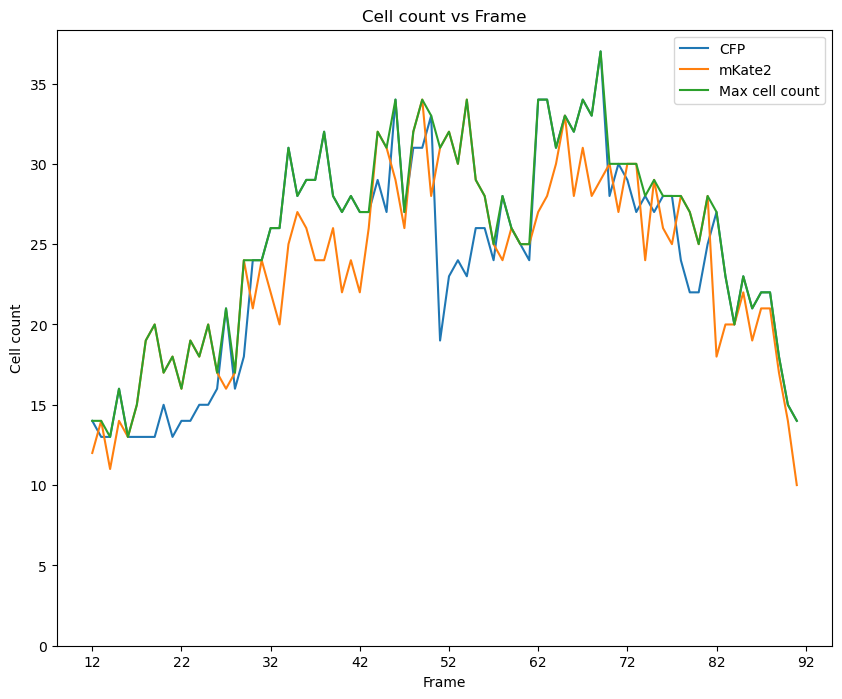

In [5]:
# Change data to only include frames 12-91
# List of tuples of the form (blue, red) 
# Check number of cells in each frame using the segmentation masks
frames = []
for i in range(12,92):
    frames.append(i)
cell_counts = []
for i in range(12,92):
    cell_counts.append(plots.cell_count(i))

cell_counts = np.array(cell_counts)
# Plot cell count
plt.figure(figsize=(10,8))
plt.plot(frames,cell_counts[:,0], label='CFP')
plt.plot(frames,cell_counts[:,1], label='mKate2')
plt.plot(frames,np.max(cell_counts, axis=1), label='Max cell count')
plt.xticks(np.arange(12, 100, step=10))
plt.xlabel('Frame')
plt.ylabel('Cell count')
plt.ylim(0)
plt.title('Cell count vs Frame')
plt.legend()

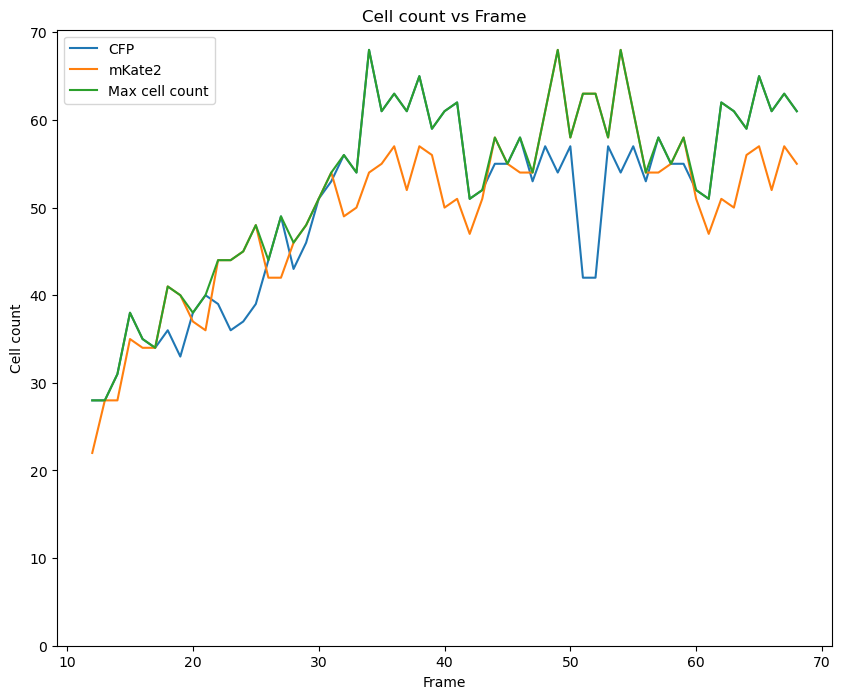

In [6]:
# Change data to only include frames 12-91
# Check number of cells in each frame using the segmentation masks
filenames = np.array([(12+i, 91-i) for i in range(len(red_offset)//2)])
cell_counts = []
for file in filenames:
    cell_counts.append(plots.cell_count(file[0])+plots.cell_count(file[1]))

cell_counts = np.array(cell_counts)
# Plot cell count
plt.figure(figsize=(10,8))
plt.plot(filenames[:,0],cell_counts[:,0], label='CFP')
plt.plot(filenames[:,0],cell_counts[:,1], label='mKate2')
plt.plot(filenames[:,0],np.max(cell_counts, axis=1), label='Max cell count')
plt.xlabel('Frame')
plt.ylabel('Cell count')
plt.ylim(0)
plt.title('Cell count vs Frame')
plt.legend()

In [12]:
from library import plots
name_of_file = 'plots/cell_scatter_aug_wimg.gif'
# plotting_function = plots.blue_red_cell_scatter
plotting_function = plots.blue_red_cell_scatter
filenames = filenames
intrinsics = []
extrinsics = []
totals = []
cv_red = []
cv_blue = []
data = {}
data['intrinsics'] = intrinsics
data['extrinsics'] = extrinsics
data['totals'] = totals 
data["cv_red"] = cv_red
data["cv_blue"] = cv_blue
data["lim"] = max_limit
data["augment"] = True
plots.create_gif_filenames(name_of_file, plotting_function, filenames, data)

Text(0.5, 1.0, 'Intrinsic Noise vs Frame')

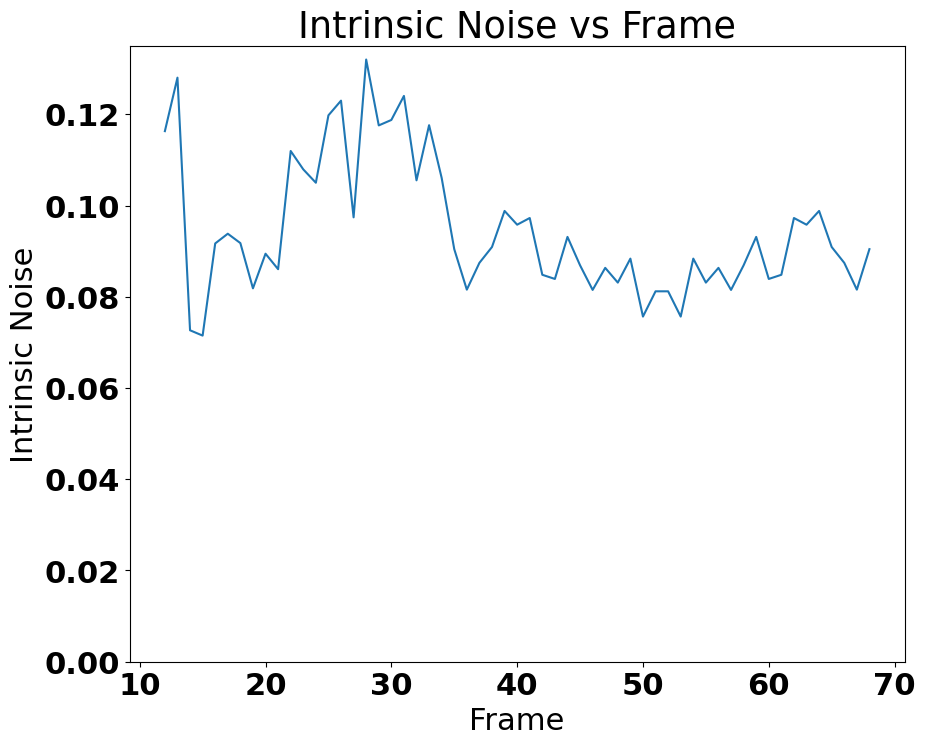

In [13]:
filenames= np.array(filenames)
# Plot intrinsic noise
plt.figure(figsize=(10,8))
plt.plot(filenames[:,0],data['intrinsics'])
plt.xlabel('Frame')
plt.ylabel('Intrinsic Noise')
plt.ylim(0)
plt.title('Intrinsic Noise vs Frame')

Text(0.5, 1.0, 'Extrinsic Noise vs Frame')

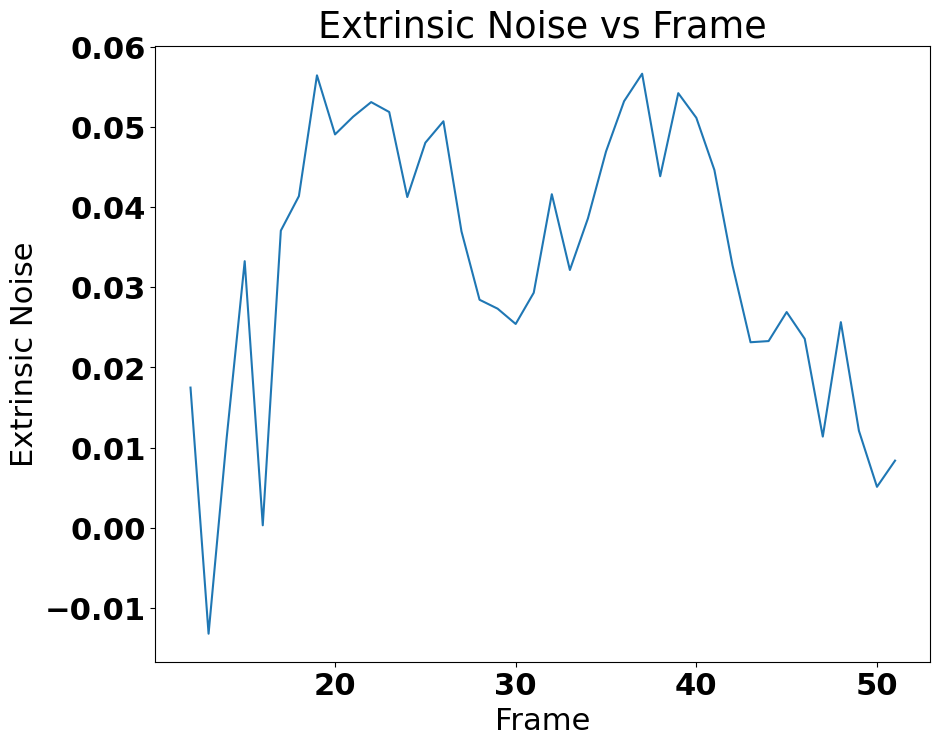

In [ ]:
# Plot extrinsic noise
plt.figure(figsize=(10,8))
plt.plot(filenames[:,0],data['extrinsics'])
plt.xlabel('Frame')
plt.ylabel('Extrinsic Noise')
plt.title('Extrinsic Noise vs Frame')

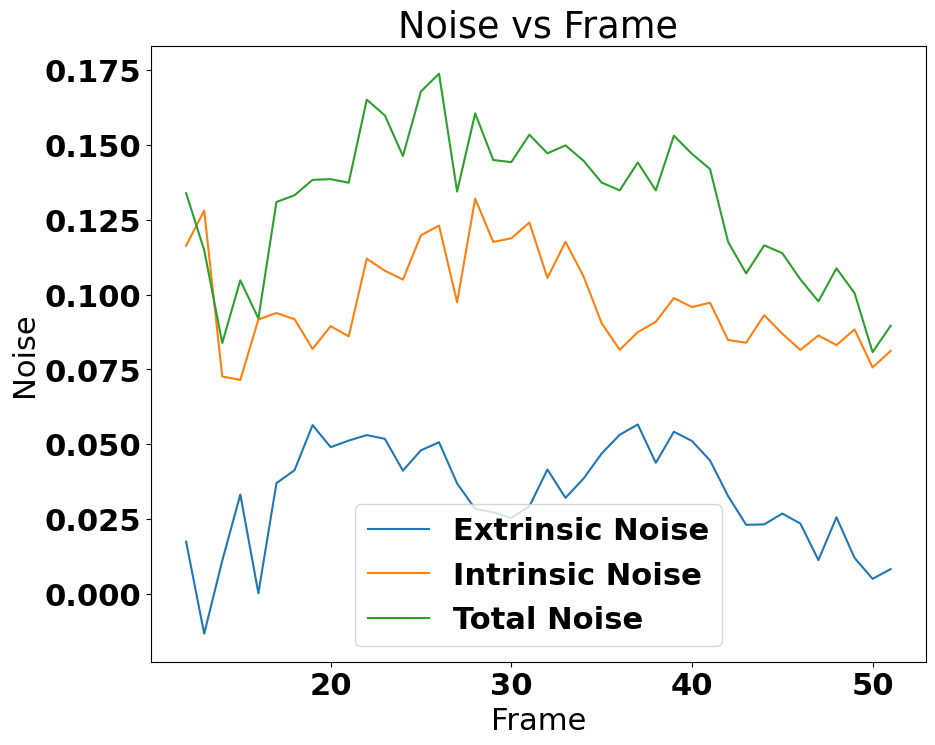

In [ ]:
# Plot total noise
plt.figure(figsize=(10,8))
plt.plot(filenames[:,0],data['extrinsics'], label='Extrinsic Noise')
plt.plot(filenames[:,0],data['intrinsics'], label='Intrinsic Noise')
plt.plot(filenames[:,0],np.array(data['totals']), label='Total Noise')
plt.xlabel('Frame')
plt.ylabel('Noise')
plt.title('Noise vs Frame')
plt.legend()

### Inner and outer data for intrinsic and extrinsic noise

/var/folders/9m/qcg58ft12w72z4h1j7s196w00000gn/T/ipykernel_96100/2040954166.py:14: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(center, 2 * major_axis_length, 2 * minor_axis_length, 0)


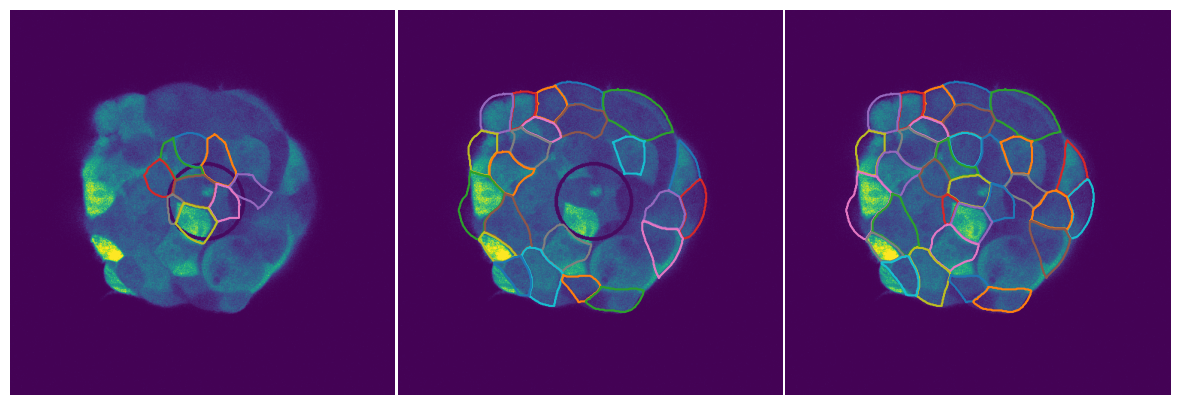

In [7]:
from library import plots
from library import helper 
from matplotlib.patches import Ellipse
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.affinity import scale
import imageio
import os
ellipse_percentage = 0.20 # need to keep this sufficiently small to make sure there is an outer and inner
file = 15

def create_ellipse_polygon(center, major_axis_length, minor_axis_length):
    # first draw the ellipse using matplotlib
    ellipse = Ellipse(center, 2 * major_axis_length, 2 * minor_axis_length, 0) 
    vertices = ellipse.get_verts()     # get the vertices from the ellipse object
    ellipse = Polygon(vertices)        # Turn it into a polygon
    return ellipse

def get_inner_outer_polygons(polygons, ellipse):
    inner = []
    outer = []
    for polygon in polygons:
        shapely_polygon = Polygon(polygon)
        if shapely_polygon.intersects(ellipse):
            inner.append(polygon)
        else:
            outer.append(polygon)
    return inner, outer

def get_means(img_blue, img_red, outlines):
    masked_imgs_red = plots.get_cell_masks(img_red,outlines)
    means_red = np.array([np.mean(plots.get_pixel_intensities(img_red, np.where(masked_img > 0))) for masked_img in masked_imgs_red])
    masked_imgs_blue = plots.get_cell_masks(img_blue,outlines)
    means_blue = np.array([np.mean(plots.get_pixel_intensities(img_blue, np.where(masked_img > 0))) for masked_img in masked_imgs_blue])
    return (means_red, means_blue)

# Get segmentation outlines
# red limit
def get_inner_outer_means(file, data):
    dat_red = np.load(f'red/{file}_seg.npy', allow_pickle=True).item()
    img_red = dat_red['img']
    # blue limit
    dat_blue = np.load(f'blue/{file}_seg.npy', allow_pickle=True).item()
    img_blue = dat_blue['img']
    comp = img_blue + img_red

    plt.close() # Close any open plots
    # Create a figure with 3 subplots side by side
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True, gridspec_kw={'width_ratios': [1, 1, 1], 'wspace':0})

    # Turn comp to 8 bit 
    comp = cv2.normalize(comp, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    clean_composite = helper._get_clean_composite(comp)

    # Use cell_count to pick which channel has the most cells
    cell_counts = plots.cell_count(file)
    outlines = plots.utils.outlines_list(dat_blue['masks']) if cell_counts[0] > cell_counts[1] else plots.utils.outlines_list(dat_red['masks'])

    # See which ones intersect with ellipse
    (major, minor), center = helper._get_ellipse(clean_composite=clean_composite, ellipse_percentage=data['ellipse_percentage'])

    ellipse_polygon = create_ellipse_polygon(center, major_axis_length=major, minor_axis_length=minor)

    # Split into points_red and points_blue tuples with (inner, outer)
    inner, outer = get_inner_outer_polygons(outlines, ellipse_polygon)
    inner, outer = get_inner_outer_polygons(outlines, ellipse_polygon)

    # Plot inner on top of composite
    img_blue_with_ellipse = img_blue.copy()
    img_blue_with_ellipse = cv2.ellipse(img_blue_with_ellipse,
                            center,
                            (major, minor)
                            ,0, 0, 360, (255, 0, 0), 3)
    ax1.imshow(img_blue_with_ellipse)
    for polygon in inner:
        ax1.plot(*polygon.T)

    # Plot outer on top of composite
    img_blue_with_ellipse = img_blue.copy()
    img_blue_with_ellipse = cv2.ellipse(img_blue_with_ellipse,
                            center,
                            (major, minor)
                            ,0, 0, 360, (255, 0, 0), 3)
    ax2.imshow(img_blue_with_ellipse)
    for polygon in outer:
        ax2.plot(*polygon.T)

    # Plot outlines and ellipse
    ax3.imshow(img_blue)
    for polygon in outlines:
        ax3.plot(*polygon.T)

    # Remove axis labels and tick marks from all subplots
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')

    # Go through the inner and outer data for intrinsic and extrinsic noise
    means_red_inner, means_blue_inner = get_means(img_blue, img_red, inner)
    means_red_outer, means_blue_outer = get_means(img_blue, img_red, outer)

    return (means_red_inner, means_blue_inner, means_red_outer, means_blue_outer)

def inner_outer_scatter(file, data):
    if type(file) != int:
        means_red_inner1, means_blue_inner1, means_red_outer1, means_blue_outer1 = get_inner_outer_means(file[0], data)
        means_red_inner2, means_blue_inner2, means_red_outer2, means_blue_outer2 = get_inner_outer_means(file[1], data)
        means_red_inner = np.concatenate((means_red_inner1, means_red_inner2))
        means_blue_inner = np.concatenate((means_blue_inner1, means_blue_inner2))
        means_red_outer  = np.concatenate((means_red_outer1, means_red_outer2))
        means_blue_outer = np.concatenate((means_blue_outer1, means_blue_outer2))
    else:
        means_red_inner, means_blue_inner, means_red_outer, means_blue_outer = get_inner_outer_means(file, data)
        
    # Get intrinsic noise for inner, outer, and total
    intrinsic_inner, extrinsic_inner, total_inner = plots.get_noise_not_centered(means_red_inner, means_blue_inner)
    intrinsic_outer, extrinsic_outer, total_outer = plots.get_noise_not_centered(means_red_outer, means_blue_outer)
    
    data['inner_count'].append(len(means_red_inner))
    data['outer_count'].append(len(means_red_outer))
    data['intrinsics_outer'].append(intrinsic_outer)
    data['intrinsics_inner'].append(intrinsic_inner)
    data['extrinsics_outer'].append(extrinsic_outer)
    data['extrinsics_inner'].append(extrinsic_inner)
    data['totals_outer'].append(total_outer)
    data['totals_inner'].append(total_inner)

intrinsics_inner = []
intrinsics_outer = []
extrinsics_inner = []
extrinsics_outer = []
totals_inner = []
totals_outer = []
inner_count = []
outer_count = []
data = {}
data['intrinsics_outer'] = intrinsics_outer
data['intrinsics_inner'] = intrinsics_inner
data['extrinsics_outer'] = extrinsics_outer
data['extrinsics_inner'] = extrinsics_inner
data['totals_outer'] = totals_outer 
data['totals_inner'] = totals_inner 
data['inner_count'] = inner_count
data['outer_count'] = outer_count
data['ellipse_percentage'] = ellipse_percentage
inner_outer_scatter(52, data)
plt.show()

In [8]:
filenames = np.array([(12+i, 91-i) for i in range(len(red_offset)//2)])
from library import plots
max_limit = max(plots.max_limit(red),plots.max_limit(blue))
# filenames = [i for i in range(12, 92)]
name_of_file = 'plots/inner_outer_seg.gif'
plotting_function = inner_outer_scatter
filenames = filenames
intrinsics_inner = []
intrinsics_outer = []
extrinsics_inner = []
extrinsics_outer = []
totals_inner = []
totals_outer = []
inner_count = []
outer_count = []
data = {}
data['intrinsics_outer'] = intrinsics_outer
data['intrinsics_inner'] = intrinsics_inner
data['extrinsics_outer'] = extrinsics_outer
data['extrinsics_inner'] = extrinsics_inner
data['totals_outer'] = totals_outer 
data['totals_inner'] = totals_inner 
data['inner_count'] = inner_count
data['outer_count'] = outer_count
data['ellipse_percentage'] = 0.2
data["lim"] = max_limit
data["augment"] = True
plots.create_gif_filenames(name_of_file, plotting_function, filenames, data)
# plots.create_gif_left_right(name_of_file, plotting_function, 12, 91, [], data, no_images=True)

/var/folders/9m/qcg58ft12w72z4h1j7s196w00000gn/T/ipykernel_96100/2040954166.py:14: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse(center, 2 * major_axis_length, 2 * minor_axis_length, 0)


Intrinsic and extrinsic noise for inner and outer of segmented spheroid

Text(0.5, 1.0, 'Intrinsic Noise')

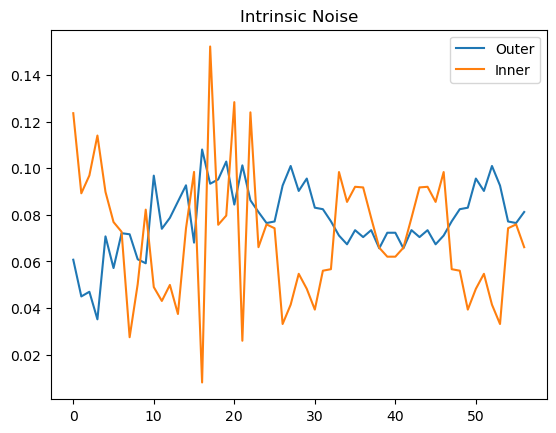

In [9]:
# Plot intrinsic_outer and intrinsic_inner
plt.plot(data['intrinsics_outer'], label='Outer')
plt.plot(data['intrinsics_inner'], label='Inner')
plt.legend()
plt.title('Intrinsic Noise')

Text(0.5, 1.0, 'Extrinsic Noise')

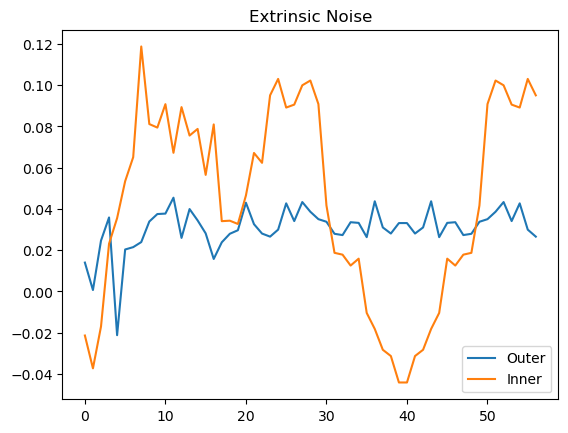

In [10]:
# Plot extrinsic_outer and extrinsic_inner
plt.plot(data['extrinsics_outer'], label='Outer')
plt.plot(data['extrinsics_inner'], label='Inner')
plt.legend()
plt.title('Extrinsic Noise')

Text(0.5, 1.0, 'Total Noise')

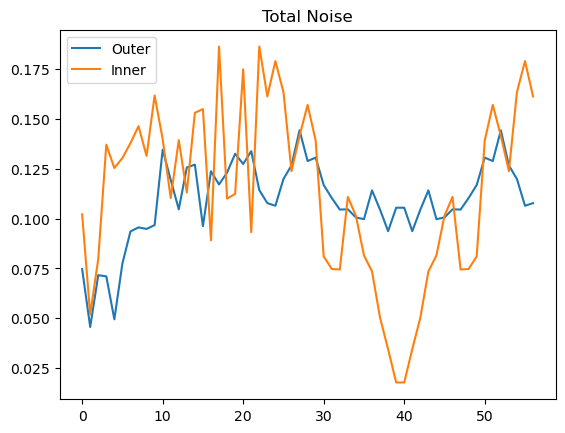

In [11]:
# Plot total_outer and total_inner
plt.plot(data['totals_outer'], label='Outer')
plt.plot(data['totals_inner'], label='Inner')
plt.legend()
plt.title('Total Noise')

In [4]:
name_of_file = 'plots/cell_mean_hist_aug.gif'
plotting_function = plots.plot_cell_mean_hist
filenames = np.array([(12+i, 91-i) for i in range(len(red_offset)//2)])
data = {}
data['max_limit'] = max_limit
data['augment'] = True
plots.create_gif_filenames(name_of_file, plotting_function, filenames, data)

/Users/danielgeorge/Documents/work/bio/spheroid/clean/spheroid-analysis/library/plots.py:154: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
